In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import numpy as np
from scipy import stats

%matplotlib inline

In [2]:
data = pd.read_csv('./hr100_odds.csv',header=0,index_col=0)

In [3]:
data

,2017,2018,2019,2017_chance,2018_chance,2019_chance
tix,,,,,,
1,736,739,778,0.6,0.4,0.3
2,435,526,552,1.2,0.9,0.6
4,252,284,340,2.4,1.7,1.1
8,177,201,229,4.7,3.4,2.3
16,73,128,155,9.2,6.7,4.5
32,42,64,104,17.6,13.2,8.8
64,10,27,45,32.2,24.4,16.8
128,1,6,18,54.1,42.6,30.8
256,0,0,1,NaN,NaN,52.3


In [4]:
# use the data to sum total number of tickets per lottery
# this looks pretty linear so a linear model for now might be reasonable
total_tix = []
for x in ['2017','2018','2019']:
    
    total_tix.append((data[x]*data.index).sum())

([<matplotlib.axis.XTick at 0x7f52b74d3a50>,
 <a list of 3 Text xticklabel objects>)

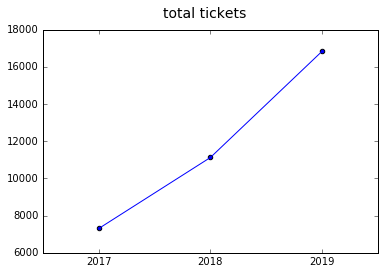

In [5]:
plt.plot(total_tix)
plt.scatter([0,1,2],total_tix)
plt.suptitle('total tickets',size=14)
plt.xticks([0,1,2],[2017,2018,2019])

In [6]:
# years to predict

ytp = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
ytp_real = 2017+ytp
print ytp_real

[2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034
 2035]


In [8]:
b0 = pymc.Normal('b0',7000,0.00001) # intercept of model of total tickets in lottery
b1 = pymc.Normal('b1',5000,0.00001) # slope of total_tickets linear model

err= pymc.Uniform('err',0,500) # error on total_tickets model

x=np.array([0,1,2]) 

# distribution of number of tickets per year with 0.9 prob of drawing 1 tix per year
my_tickets = pymc.Binomial('num tix',p=0.9,n=np.array([ytp-1])) 

# the model
@pymc.deterministic
def total_pool_pred(b0=b0,b1=b1,x=x):
    return b0+b1*x

#estimate values of the model based on data
total_pool = pymc.Normal('y', total_pool_pred , err, value=np.array(total_tix), observed=True)

# use fitted params to estimate population size at each year
pop_size = pymc.Normal('population',mu=b1*ytp+b0,tau=err,size=len(ytp))


def chance_final(foonum=my_tickets,pop_size=pop_size):
    tmp = (2**foonum)/pop_size
    tmp[tmp>1] = 1
    return tmp

chances = pymc.Deterministic(name='chances',eval=chance_final,parents={"foonum":my_tickets,"pop_size":pop_size},doc='foo')
                            
# how many draws until success,                              
final = pymc.Geometric('final_odds',p=chances)


model = pymc.Model([total_pool_pred, b0, b1, total_pool, err, x,pop_size,chances,my_tickets,final])


In [9]:
mcmc = pymc.MCMC(model)
mcmc.sample(100000, 20000)

/home/adam/anaconda2/lib/python2.7/site-packages/pymc/StepMethods.py:782: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


 [-----------------100%-----------------] 100000 of 100000 complete in 25.9 sec

(0, 250)

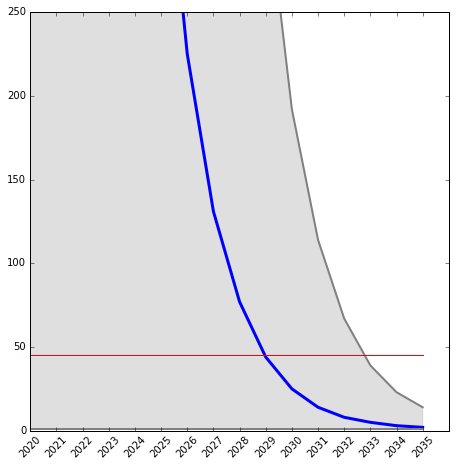

In [11]:
fo_central = final.stats()['quantiles'][50]
fo_ub = final.stats()['95% HPD interval'][1]
fo_lb = final.stats()['95% HPD interval'][0]


plt.figure(figsize=[7.5,7.5])
plt.plot(fo_central,linewidth=3)
plt.plot(fo_ub,c='grey',linewidth=2)
plt.plot(fo_lb,c='grey',linewidth=2)
plt.fill_between(np.arange(0,len(ytp_real+1),1),fo_ub,fo_lb,color='grey',alpha=0.25)
plt.plot([0,15],[45,45],c='red')
plt.xticks(np.arange(0,len(ytp_real+1),1),ytp_real,rotation=45)
plt.ylim([0,250])

In [ ]:
print np.mean(mcmc.trace('b0')[:])
print np.mean(mcmc.trace('b1')[:])

plt.hist(mcmc.trace('b0')[:], bins=50)

In [19]:
for x in xrange(14):
    print ytp_real[x],sum(np.mean(mcmc.trace('final_odds')[:],1)[:,x]<=45)/80000.0

2020 0.00805
2021 0.0114875
2022 0.0190375
2023 0.0317125
2024 0.0496625
2025 0.0835
2026 0.139175
2027 0.223675
2028 0.3467875
2029 0.5118875
2030 0.6772625
2031 0.8187
2032 0.911175
2033 0.9616375


In [ ]:
final.stats()

(80000, 16)